# Process the Load Data for the NTP Heat Wave Grid Stress Events


In [1]:
# Start by importing the packages we need:
import os
import glob
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the data input and image output directory:
data_dir =  '/Users/burl878/Documents/Code/code_repos/ntp_heat_wave_loads/data/'
plot_dir =  '/Users/burl878/Documents/Code/code_repos/ntp_heat_wave_loads/plots/'


## Suppress Future Warnings


In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)


## Create a Function to Process the 2035 GridView Data Used in Scaling


In [4]:
def process_gridview_data(data_dir: str):
    
    # Read in the raw data .csv file:
    gv_df = pd.read_csv((data_dir + 'wecc_load_2035.csv'))
    
    # Subset to just the annual total demand by BA:
    gv_df = gv_df[-3:-2]
       
    # Strip the unecessary bits from the column names:
    gv_df.columns = gv_df.columns.str.replace("_CEC", "")
    gv_df.columns = gv_df.columns.str.replace("_2030.dat", "")
    gv_df.columns = gv_df.columns.str.replace("Load_", "")
       
    # Delete the index and last column:
    del gv_df["Index"], gv_df["Unnamed: 38"]
    
    # Compute the total loads for CISO, IPCO, NEVP, and PACE:
    gv_df['CISO'] = (gv_df['CIPB'] + gv_df['CIPV'] + gv_df['CISC'] + gv_df['CISD'] + gv_df['VEA']).round(2)
    gv_df['IPCO'] = (gv_df['IPFE'] + gv_df['IPMV'] + gv_df['IPTV']).round(2)
    gv_df['PACE'] = (gv_df['PAID'] + gv_df['PAUT'] + gv_df['PAWY']).round(2)
    gv_df['NEVP_Sum'] = (gv_df['NEVP'] + gv_df['SPPC']).round(2)
           
    # Rename a few columns for consistency:
    gv_df.rename(columns={'CIPB': 'CISO_CIPB', 'CIPV': 'CISO_CIPV', 'CISC': 'CISO_CISC', 'CISD': 'CISO_CISD', 'VEA': 'CISO_VEA',
                          'IPFE': 'IPCO_IPFE', 'IPMV': 'IPCO_IPMV', 'IPTV': 'IPCO_IPTV',
                          'NEVP': 'NEVP_NEVP', 'SPPC': 'NEVP_SPPC',
                          'PAID': 'PACE_PAID', 'PAUT': 'PACE_PAUT', 'PAWY': 'PACE_PAWY'}, inplace=True) 
    gv_df.rename(columns={'NEVP_Sum': 'NEVP'}, inplace=True) 
    
    # Squeeze the dataframe:
    gv_df = gv_df.squeeze().to_frame()
        
    # Rename the columns:
    gv_df.reset_index(inplace=True)
    gv_df = gv_df.rename(columns = {'index':'BA'})
    gv_df.rename(columns={gv_df.columns[1]: "Total_Load_MWh" }, inplace = True)
       
    # Sort the dataframe alphabetically by BA name:
    gv_df = gv_df.sort_values('BA')
       
    # Return the output dataframe:
    return gv_df


## Create a Function to Aggregate the Raw TELL MLP Output into a Single Dataframe:


In [5]:
def aggregate_mlp_output_files(data_dir: str, year_to_process: str):
    
    # Create a list of all of the MLP output files in the "mlp_input_dir" and aggregate the files in that list:
    list_of_files = sorted(glob.glob(os.path.join(data_dir, 'TELL_Data', year_to_process, '*_mlp_output.csv')))

    # Loop over the list of MLP output files:
    for file in range(len(list_of_files)):

        # Read in the .csv file and replace missing values with nan:
        mlp_data = pd.read_csv(list_of_files[file]).replace(-9999, np.nan)

        # Rename the "Load" variable:
        mlp_data.rename(columns={'Load': 'Hourly_Load_MWh'}, inplace=True)

        # Replacing missing or negative loads with NaN:
        mlp_data.loc[~(mlp_data['Hourly_Load_MWh'] > 0), 'Hourly_Load_MWh'] = np.nan

        # Aggregate the output into a new dataframe:
        if file == 0:
            tell_df = mlp_data
        else:
            tell_df = pd.concat([tell_df, mlp_data])
    
    # Return the output dataframe:
    return tell_df


## Create a Function to Scale the TELL Output Based on the GridView 2035 Values:


In [6]:
def scale_tell_loads(data_dir: str, year_to_process: str):
    
    # Aggregate the TELL MLP files:
    tell_df = aggregate_mlp_output_files(data_dir = data_dir,
                                         year_to_process = year_to_process)
    
    # Read in the processed GridView file and rename a column for consistency:
    gv_df = process_gridview_data(data_dir = data_dir)
    gv_df.rename(columns={'Total_Load_MWh': 'GV_Total_Load_MWh'}, inplace=True) 
    
    # Merge the tell_df and gv_df dataframes based on common BA names:
    merged_df = tell_df.merge(gv_df, on=['BA'])
    
    # Sum the hourly TELL loads by BA into annual total loads:
    merged_df['TELL_Total_Load_MWh'] = merged_df.groupby('BA')['Hourly_Load_MWh'].transform('sum')
    
    # Compute the scaling factors that force the annual total loads to agree:
    merged_df['Scaling_Factor'] = merged_df['GV_Total_Load_MWh'] / merged_df['TELL_Total_Load_MWh']
    
    # Compute the scaled hourly loads:
    merged_df['Hourly_Load_MWh_Scaled'] = merged_df['Hourly_Load_MWh'] * merged_df['Scaling_Factor']
    
    # Compute the hours since the start of the year:
    merged_df['Hour'] = ((pd.to_datetime(merged_df['Time_UTC']) - datetime.datetime(int(year_to_process), 1, 1, 0, 0, 0)) / np.timedelta64(1, 'h') + 1).astype(int)
    
    # Only keep the columns that are needed:
    scaled_tell_df = merged_df[['Hour', 'BA', 'Hourly_Load_MWh_Scaled']].copy()
    
    # Drop the rows with missing values (i.e., there is not a corresponding GridView load):
    scaled_tell_df = scaled_tell_df.dropna(how = 'any')
    
    # Rename the load variable and round it to 5 decimals:
    scaled_tell_df.rename(columns={'Hourly_Load_MWh_Scaled': 'Load_MWh'}, inplace=True)
    scaled_tell_df['Load_MWh'] = scaled_tell_df['Load_MWh'].round(5)
    
    # Return the output dataframe:
    return scaled_tell_df


## Create a Function to Format the Output for Ingest to GridView:


In [7]:
def format_scaled_tell_loads(data_dir: str, year_to_process: str):
    
    # Process the GridView file:
    gv_df = process_gridview_data(data_dir = data_dir)
    
    # Compute the load fractions for the subregions:
    CIPB_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CIPB')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    CIPV_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CIPV')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    CISC_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CISC')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    CISD_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CISD')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    VEA_LF  = (gv_df.loc[(gv_df['BA'] == 'CISO_VEA' )]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    IPFE_LF = (gv_df.loc[(gv_df['BA'] == 'IPCO_IPFE')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'IPCO')]['Total_Load_MWh'].values[0])
    IPMV_LF = (gv_df.loc[(gv_df['BA'] == 'IPCO_IPMV')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'IPCO')]['Total_Load_MWh'].values[0])
    IPTV_LF = (gv_df.loc[(gv_df['BA'] == 'IPCO_IPTV')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'IPCO')]['Total_Load_MWh'].values[0])
    NEVP_LF = (gv_df.loc[(gv_df['BA'] == 'NEVP_NEVP')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'NEVP')]['Total_Load_MWh'].values[0])
    SPPC_LF = (gv_df.loc[(gv_df['BA'] == 'NEVP_SPPC')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'NEVP')]['Total_Load_MWh'].values[0])
    PAID_LF = (gv_df.loc[(gv_df['BA'] == 'PACE_PAID')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'PACE')]['Total_Load_MWh'].values[0])
    PAUT_LF = (gv_df.loc[(gv_df['BA'] == 'PACE_PAUT')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'PACE')]['Total_Load_MWh'].values[0])
    PAWY_LF = (gv_df.loc[(gv_df['BA'] == 'PACE_PAWY')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'PACE')]['Total_Load_MWh'].values[0])
    
    # Aggregate the TELL MLP files:
    scaled_tell_df = scale_tell_loads(data_dir = data_dir, 
                                      year_to_process = year_to_process)
   
    # Reshape the dataframe and drop the indexes:
    load_df = scaled_tell_df.pivot(index = 'Hour', columns = 'BA', values = 'Load_MWh')
    load_df = load_df.reset_index(drop=False)
    
    # Add back in the text to the column headers:
    load_df = load_df.add_suffix('_2030.dat')
    load_df = load_df.add_prefix('Load_')
    
    # Rename the time variable:
    load_df.rename(columns={'Load_Hour_2030.dat': 'Index'}, inplace=True)
    
    # Compute the loads for the subregions:
    load_df['Load_CIPB_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CIPB_LF
    load_df['Load_CIPV_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CIPV_LF
    load_df['Load_CISC_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CISC_LF
    load_df['Load_CISD_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CISD_LF
    load_df['Load_VEA_2030.dat'] = load_df['Load_CISO_2030.dat'] * VEA_LF
    load_df['Load_IPFE_2030.dat'] = load_df['Load_IPCO_2030.dat'] * IPFE_LF
    load_df['Load_IPMV_2030.dat'] = load_df['Load_IPCO_2030.dat'] * IPMV_LF
    load_df['Load_IPTV_2030.dat'] = load_df['Load_IPCO_2030.dat'] * IPTV_LF
    load_df['Load_NEVP_Temp_2030.dat'] = load_df['Load_NEVP_2030.dat'] * NEVP_LF
    load_df['Load_SPPC_2030.dat'] = load_df['Load_NEVP_2030.dat'] * SPPC_LF
    load_df['Load_PAID_2030.dat'] = load_df['Load_PACE_2030.dat'] * PAID_LF
    load_df['Load_PAUT_2030.dat'] = load_df['Load_PACE_2030.dat'] * PAUT_LF
    load_df['Load_PAWY_2030.dat'] = load_df['Load_PACE_2030.dat'] * PAWY_LF
    
    # Drop the un-needed columns for BAs with subregions:
    del load_df['Load_NEVP_2030.dat'], load_df['Load_CISO_2030.dat'], load_df['Load_IPCO_2030.dat'], load_df['Load_PACE_2030.dat']
    
    # Clean up the NEVP naming:
    load_df.rename(columns={'Load_NEVP_Temp_2030.dat': 'Load_NEVP_2030.dat'}, inplace=True)
    
    # Create a target dataframe with the spare hours:
    target_df = pd.DataFrame({"Index": np.arange(1,8791,1)})
    
    # Merge load dataframe with the target dataframe:
    merged_df = target_df.merge(load_df, on=['Index'], how='left')
    
    # Compute the summary statistics:
    stats_df = merged_df.apply(['mean','sum','max','min'])
    
    # Fix the summary statistic labels:
    stats_df.iloc[0, 0] = 'AVG'
    stats_df.iloc[1, 0] = 'SUM'
    stats_df.iloc[2, 0] = 'MAX'
    stats_df.iloc[3, 0] = 'MIN'
      
    # Sort the data by column name and make the Index column appear first:
    merged_df.rename(columns={'Index': 'AA'}, inplace=True)
    merged_df = merged_df.sort_index(axis = 1)
    merged_df.rename(columns={'AA': 'Index'}, inplace=True)
    
    # Add in a blank row and fill it with the year placeholder:
    merged_df.loc[-0.5] = 0
    merged_df = merged_df.sort_index().reset_index(drop=True)
    merged_df.iloc[0, :] = '2030'
    merged_df.at[0, 'Index'] = 'Year'
        
    # Merge the hourly load data and statistics dataframes together:
    output_df = pd.concat([merged_df, stats_df], axis=0)
    
    # Replace NaNs with blank values:
    output_df.replace(np.nan, "", regex=True)
    
    # Set the output filename:
    if year_to_process == '2009':
       output_filename = 'TELL_Loads_2035_Based_on_2009_Weather.csv'
    if year_to_process == '2015':
       output_filename = 'TELL_Loads_2035_Based_on_2015_Weather.csv'
    if year_to_process == '2018':
       output_filename = 'TELL_Loads_2035_Based_on_2018_Weather.csv'
    if year_to_process == '2055':
       output_filename = 'TELL_Loads_2035_Based_on_2015_Weather_With_Climate_Change.csv'
    if year_to_process == '2058':
       output_filename = 'TELL_Loads_2035_Based_on_2018_Weather_With_Climate_Change.csv'
    
    # Write out the dataframe to a .csv file:
    output_df.to_csv((os.path.join(data_dir, output_filename)), sep=',', index=False)
    
    # Return the output dataframe:
    return output_df


## Call the Necessary Functions to Process the Data:


In [8]:
output_df = format_scaled_tell_loads(data_dir = data_dir,
                                     year_to_process = '2009')

output_df


,Index,Load_AVA_2030.dat,Load_AZPS_2030.dat,Load_BANC_2030.dat,Load_BPAT_2030.dat,Load_CHPD_2030.dat,Load_CIPB_2030_CEC.dat,Load_CIPV_2030_CEC.dat,Load_CISC_2030_CEC.dat,Load_CISD_2030_CEC.dat,...,Load_SCL_2030.dat,Load_SPPC_2030.dat,Load_SRP_2030.dat,Load_TEPC_2030.dat,Load_TIDC_2030.dat,Load_TPWR_2030.dat,Load_VEA_2030.dat,Load_WACM_2030.dat,Load_WALC_2030.dat,Load_WAUW_2030.dat
0,Year,2030,2030,2030,2030,2030,2030,2030,2030,2030,...,2030,2030,2030,2030,2030,2030,2030,2030,2030,2030
1,1,2313.27026,4098.93034,2497.6809,8814.58484,400.26059,5641.429813,6696.214104,17538.276801,3761.098945,...,1649.02492,1421.859909,4451.61275,2210.97629,297.44568,814.75168,119.626978,4491.95046,1248.06313,137.86927
2,2,2362.35254,4522.7081,2771.46309,9091.00307,408.61121,6061.11627,7194.369796,18843.012923,4040.900758,...,1674.9904,1539.286235,4789.3575,2295.86667,345.9723,830.84131,128.526463,4558.63351,1318.59289,136.86237
3,3,2414.26059,4741.13634,2861.58647,9332.83846,407.13087,6303.064074,7481.554844,19595.188823,4202.205544,...,1696.6537,1584.108838,4928.15971,2279.23923,357.46045,839.6678,133.656986,4616.92126,1327.7975,135.91919
4,4,2489.31778,4874.57532,3002.01652,9561.21332,403.17065,6558.70722,7784.995869,20389.94129,4372.640912,...,1731.96206,1621.070148,5056.17871,2276.69293,365.29082,849.77539,139.077919,4623.89224,1334.87236,134.96327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,8790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,AVG,1941.050589,5224.455555,2772.862414,7502.141502,267.389744,6373.710425,7565.410021,19814.816701,4249.304936,...,1321.315156,1642.853985,5639.124546,2231.22475,412.295294,614.396439,135.155047,4003.466186,1508.008715,118.237176
sum,SUM,17003603.15959,45766230.66011,24290274.7496,65718759.55986,2342334.15571,55833703.319983,66272991.77998,173577794.299948,37223911.239989,...,11574720.76996,14391400.910052,49398731.02025,19545528.81001,3611706.77372,5382112.80126,1183958.215,35070363.79072,13210156.33998,1035757.66143
max,MAX,2999.48949,10887.94382,5872.18952,11948.07001,561.74394,11300.008153,13412.783013,35129.86555,7533.630684,...,1958.99298,3187.704545,11599.78349,4533.07117,815.36098,985.01726,239.617591,5323.87937,2325.27941,184.90057


## Create a Function to Create Summary Plots of the Output


In [9]:
def create_summary_plots(data_dir: str, year_to_process: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the raw data .csv file:
    gv_df = pd.read_csv((data_dir + 'wecc_load_2035.csv'))
    
    # Strip the unecessary bits from the column names:
    gv_df.columns = gv_df.columns.str.replace("_CEC", "")
    gv_df.columns = gv_df.columns.str.replace("_2030.dat", "")
    gv_df.columns = gv_df.columns.str.replace("Load_", "")
    
    # Delete the random column:
    del gv_df["Unnamed: 38"]
    
    # Subset to just the annual total demand by BA:
    gv_stats = gv_df[8791:8795]
    
    # Reshape the dataframe and rename the index column:
    gv_stats_df = pd.melt(gv_stats, id_vars='Index', var_name='BA', value_name='GV_Value')
    gv_stats_df.rename(columns={'Index': 'Statistic'}, inplace=True)
    
    # Drop the first row and last 4 rows:
    gv_df = gv_df.tail(-1).iloc[:-4, :]
    
    # Compute the hourly total load across BAs:
    gv_df['GV_Total_Load_MWh'] = gv_df.sum(axis=1)
    
    # Copy the total load to a new dataframe:
    gv_load_df = gv_df[['Index', 'GV_Total_Load_MWh']].copy().iloc[0:8760, :]
    gv_load_df.rename(columns={'Index': 'Hour'}, inplace=True)
    
    # Set the output filename:
    if year_to_process == '2009':
       output_filename = 'TELL_Loads_2035_Based_on_2009_Weather.csv'
    if year_to_process == '2015':
       output_filename = 'TELL_Loads_2035_Based_on_2015_Weather.csv'
    if year_to_process == '2055':
       output_filename = 'TELL_Loads_2035_Based_on_2015_Weather_With_Climate_Change.csv'
    if year_to_process == '2058':
       output_filename = 'TELL_Loads_2035_Based_on_2018_Weather_With_Climate_Change.csv'
    
    # Read in the raw TELL data .csv file:
    tell_df = pd.read_csv((data_dir + output_filename))
    
    # Strip the unecessary bits from the column names:
    tell_df.columns = tell_df.columns.str.replace("_CEC", "")
    tell_df.columns = tell_df.columns.str.replace("_2030.dat", "")
    tell_df.columns = tell_df.columns.str.replace("Load_", "")
    
    # Subset to just the annual total demand by BA:
    tell_stats = tell_df[8791:8795]
    
    # Reshape the dataframe and rename the index column:
    tell_stats_df = pd.melt(tell_stats, id_vars='Index', var_name='BA', value_name='TELL_Value')
    tell_stats_df.rename(columns={'Index': 'Statistic'}, inplace=True)
    
    # Merge the two statistics dataframes together:
    stats_df = pd.merge(gv_stats_df, tell_stats_df, on=['Statistic', 'BA'])
    
    # Drop the first row and last 4 rows:
    tell_df = tell_df.tail(-1).iloc[:-4, :]
    
    # Compute the hourly total load across BAs:
    tell_df['TELL_Total_Load_MWh'] = tell_df.sum(axis=1)
    
    # Copy the total load to a new dataframe:
    tell_load_df = tell_df[['Index', 'TELL_Total_Load_MWh']].copy().iloc[0:8760, :]
    tell_load_df.rename(columns={'Index': 'Hour'}, inplace=True)
    
    # Merge the two load dataframes together:
    load_df = pd.merge(gv_load_df, tell_load_df, on=['Hour'])
    
    # Compute the min and max loads:
    min_load = load_df[['GV_Total_Load_MWh','TELL_Total_Load_MWh']].min().min()
    max_load = load_df[['GV_Total_Load_MWh','TELL_Total_Load_MWh']].max().max()
    
    # Subset the statistics dataframe:
    avg_df = stats_df.loc[stats_df['Statistic'] == 'AVG']; avg_min = 0.95*avg_df[['GV_Value','TELL_Value']].min().min(); avg_max = 1.05*avg_df[['GV_Value','TELL_Value']].max().max()
    sum_df = stats_df.loc[stats_df['Statistic'] == 'SUM']; sum_min = 0.95*sum_df[['GV_Value','TELL_Value']].min().min(); sum_max = 1.05*sum_df[['GV_Value','TELL_Value']].max().max()
    min_df = stats_df.loc[stats_df['Statistic'] == 'MIN']; min_min = 0.95*min_df[['GV_Value','TELL_Value']].min().min(); min_max = 1.05*min_df[['GV_Value','TELL_Value']].max().max()
    max_df = stats_df.loc[stats_df['Statistic'] == 'MAX']; max_min = 0.95*max_df[['GV_Value','TELL_Value']].min().min(); max_max = 1.05*max_df[['GV_Value','TELL_Value']].max().max()
    
    # Set the output filename:
    if year_to_process == '2009':
       load_filename = 'Load_Time_Series_2009_Weather.png'
       stats_filename = 'Load_Statistics_2009_Weather.png'
       plot_title_a = 'TELL Total Loads Based on 2009 Weather'
    if year_to_process == '2015':
       load_filename = 'Load_Time_Series_2015_Weather.png'
       stats_filename = 'Load_Statistics_2015_Weather.png'
       plot_title_a = 'TELL Total Loads Based on 2015 Weather'
    if year_to_process == '2055':
       load_filename = 'Load_Time_Series_2015_Weather_With_Climate_Change.png'
       stats_filename = 'Load_Statistics_2015_Weather_With_Climate_Change.png'
       plot_title_a = 'TELL Total Loads Based on 2015 Weather With Climate Change'
    if year_to_process == '2058':
       load_filename = 'Load_Time_Series_2018_Weather_With_Climate_Change.png'
       stats_filename = 'Load_Statistics_2018_Weather_With_Climate_Change.png'
       plot_title_a = 'TELL Total Loads Based on 2018 Weather With Climate Change'
    
    # Make the total load time series plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(211)
    plt.plot(load_df['Hour'], load_df['GV_Total_Load_MWh'], color='black', linestyle='-', label='Original GridView Loads', linewidth=0.5)
    plt.xlim([0, 8760]); plt.xticks([0, 8760],['0','8760']); plt.xlabel('')
    plt.ylim([min_load, max_load]); plt.ylabel('WECC Total Load [MWh]')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Original Total Loads for 2035')
        
    plt.subplot(212)
    plt.plot(load_df['Hour'], load_df['TELL_Total_Load_MWh'], color='black', linestyle='-', label='TELL Total Loads', linewidth=0.5)
    plt.xlim([0, 8760]); plt.xticks([0, 8760],['0','8760']); plt.xlabel('Hour of Year [--->]')
    plt.ylim([min_load, max_load]); plt.ylabel('WECC Total Load [MWh]') 
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title(plot_title_a)
        
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, load_filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    
    
    
    # Make the statistics plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(221)
    plt.plot([avg_min, avg_max], [avg_min, avg_max], color='k', linestyle='-', linewidth=1)
    plt.scatter(avg_df['GV_Value'], avg_df['TELL_Value'], s=50, c='blue')
    plt.xlim([avg_min, avg_max]); plt.ylim([avg_min, avg_max]);
    plt.xlabel('Original GridView Average Load [MWh]')
    plt.ylabel('TELL Average Load [MWh]')
    plt.title('Balancing Authority Annual Average Load')
        
    plt.subplot(222)
    plt.plot([sum_min, sum_max], [sum_min, sum_max], color='k', linestyle='-', linewidth=1)
    plt.scatter(sum_df['GV_Value'], sum_df['TELL_Value'], s=50, c='blue')
    plt.xlim([sum_min, sum_max]); plt.ylim([sum_min, sum_max]);
    plt.xlabel('Original GridView Annual Total Load [MWh]')
    plt.ylabel('TELL Annual Total Load [MWh]')
    plt.title('Balancing Authority Annual Total Load')
        
    plt.subplot(223)
    plt.plot([min_min, min_max], [min_min, min_max], color='k', linestyle='-', linewidth=1)
    plt.plot([min_min, min_max], [min_min, 0.9*min_max], color='k', linestyle='--', linewidth=1)
    plt.plot([min_min, min_max], [min_min, 1.1*min_max], color='k', linestyle='--', linewidth=1)
    plt.scatter(min_df['GV_Value'], min_df['TELL_Value'], s=50, c='blue')
    plt.xlim([min_min, min_max]); plt.ylim([min_min, min_max]);
    plt.xlabel('Original GridView Minimum Load [MWh]')
    plt.ylabel('TELL Minimum Load [MWh]')
    plt.title('Balancing Authority Annual Minimum Load')
    
    plt.subplot(224)
    plt.plot([max_min, max_max], [max_min, max_max], color='k', linestyle='-', linewidth=1)
    plt.plot([max_min, max_max], [max_min, 0.9*max_max], color='k', linestyle='--', linewidth=1)
    plt.plot([max_min, max_max], [max_min, 1.1*max_max], color='k', linestyle='--', linewidth=1)
    plt.scatter(max_df['GV_Value'], max_df['TELL_Value'], s=50, c='blue')
    plt.xlim([max_min, max_max]); plt.ylim([max_min, max_max]);
    plt.xlabel('Original GridView Maximum Load [MWh]')
    plt.ylabel('TELL Maximum Load [MWh]')
    plt.title('Balancing Authority Annual Maximum Load')
    
    plt.subplots_adjust(wspace=0.15, hspace=0.4)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, stats_filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


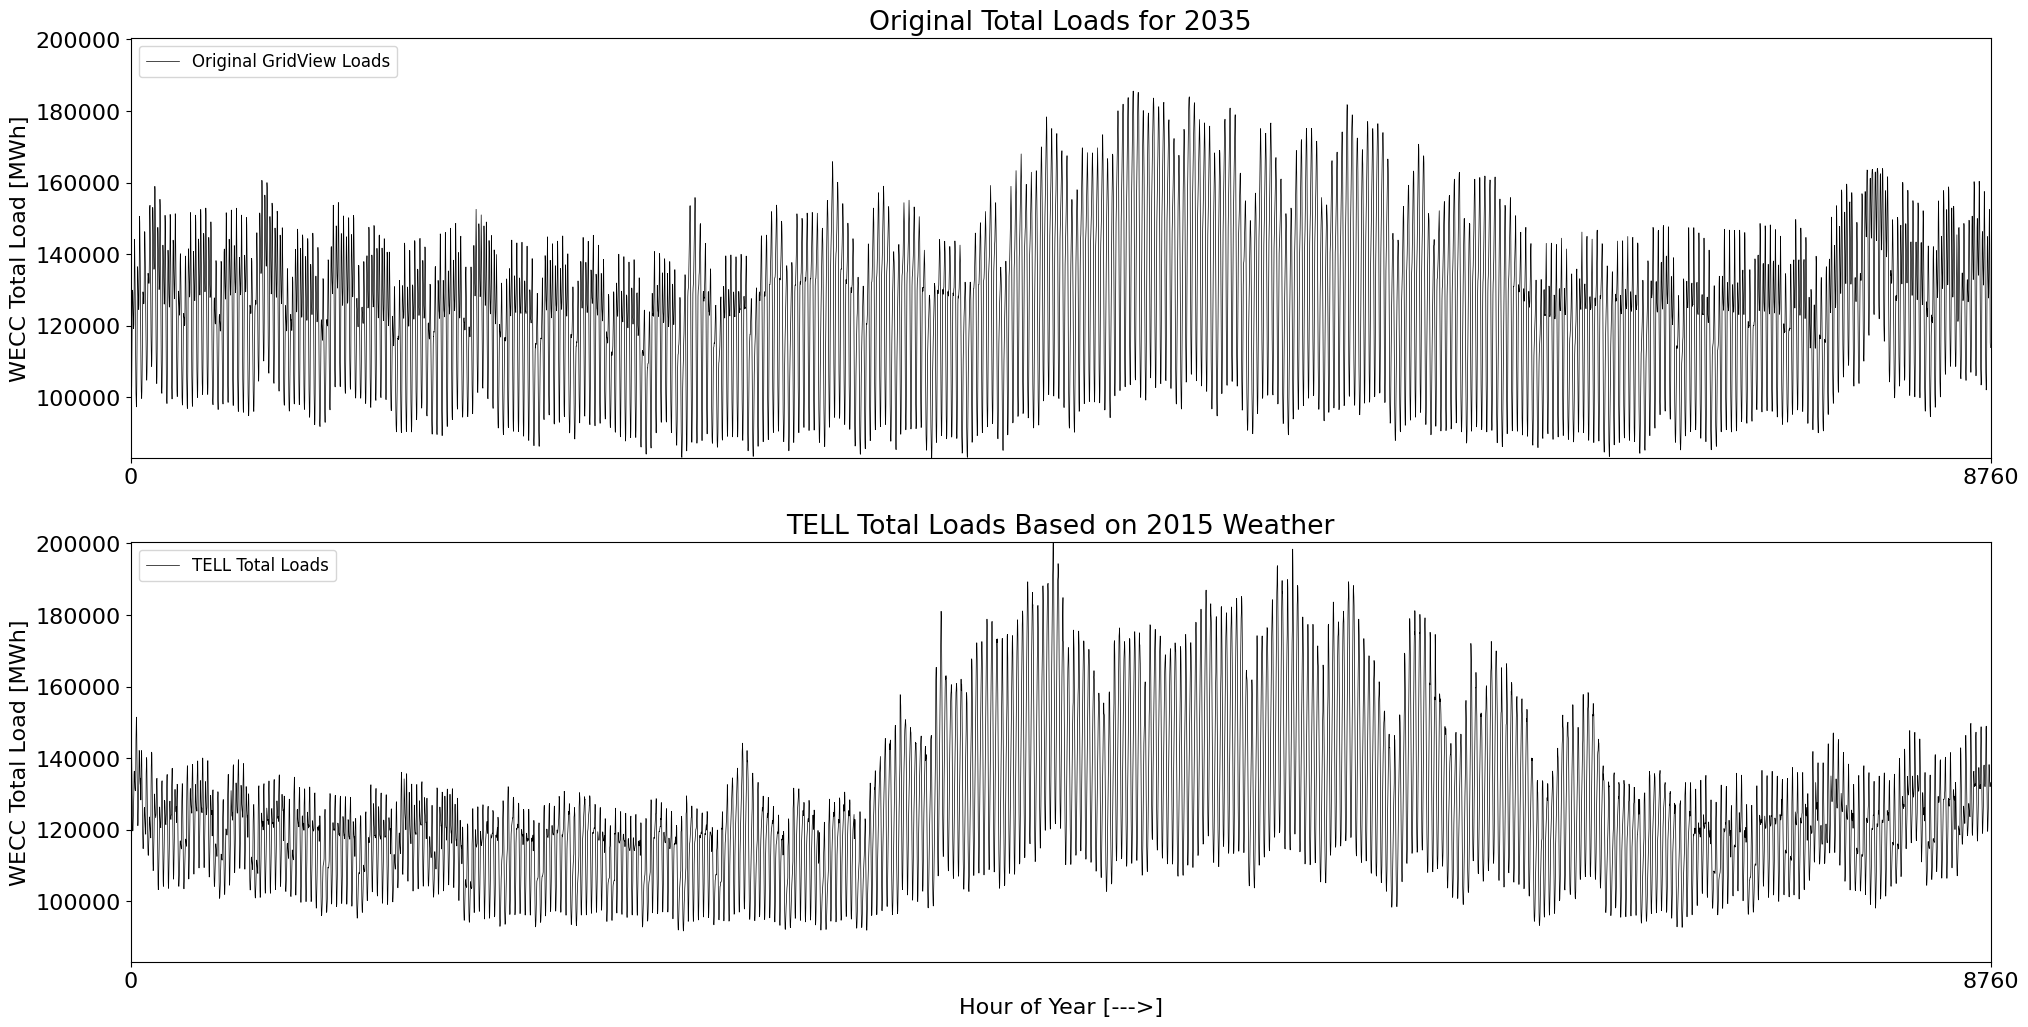

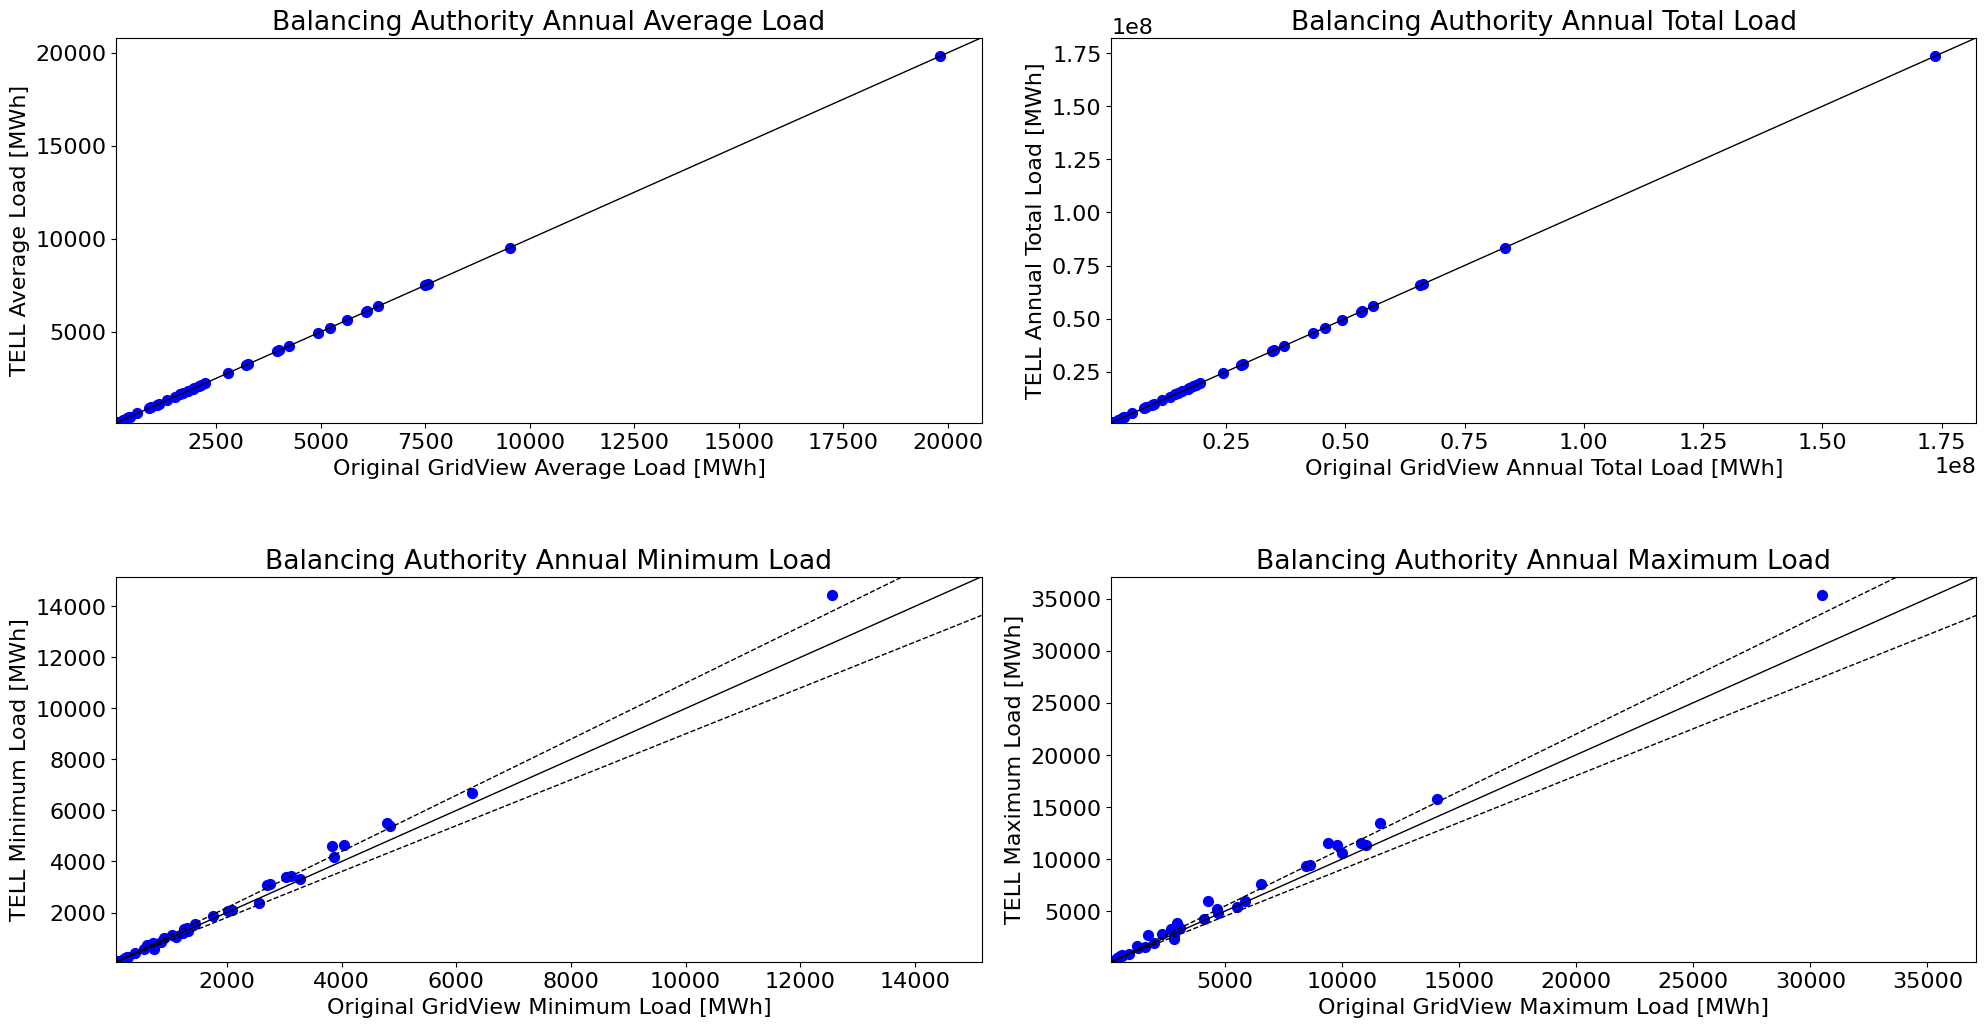

In [10]:
create_summary_plots(data_dir = data_dir,
                     year_to_process = '2015',
                     image_output_dir = plot_dir, 
                     image_resolution = 300, 
                     save_images = False)


## Create a Function to Create Plots Quantifying the Climate Change Impact


In [15]:
def climate_change_impact_plots(data_dir: str, year_to_process: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Set the output filename:
    if year_to_process == '2015':
       base_filename = 'TELL_Loads_2035_Based_on_2015_Weather.csv'
       clim_filename = 'TELL_Loads_2035_Based_on_2015_Weather_With_Climate_Change.csv'
    if year_to_process == '2018':
       base_filename = 'TELL_Loads_2035_Based_on_2018_Weather.csv'
       clim_filename = 'TELL_Loads_2035_Based_on_2018_Weather_With_Climate_Change.csv'
    
    # Read in the raw TELL data .csv file:
    base_tell_df = pd.read_csv((data_dir + base_filename))
    
    # Strip the unecessary bits from the column names:
    base_tell_df.columns = base_tell_df.columns.str.replace("_CEC", "")
    base_tell_df.columns = base_tell_df.columns.str.replace("_2030.dat", "")
    base_tell_df.columns = base_tell_df.columns.str.replace("Load_", "")
    
    # Drop the first row and last 4 rows:
    base_tell_df = base_tell_df.tail(-1).iloc[:-4, :]
    
    # Compute the hourly total load across BAs:
    base_tell_df['TELL_Total_Load_MWh'] = base_tell_df.sum(axis=1)
    
    # Copy the total load to a new dataframe:
    tell_base_load_df = base_tell_df[['Index', 'TELL_Total_Load_MWh']].copy().iloc[0:8760, :]
    tell_base_load_df.rename(columns={'Index': 'Hour', 'TELL_Total_Load_MWh': 'Base_Load_MWh'}, inplace=True)
    
      
    # Read in the raw TELL data .csv file:
    clim_tell_df = pd.read_csv((data_dir + clim_filename))
    
    # Strip the unecessary bits from the column names:
    clim_tell_df.columns = clim_tell_df.columns.str.replace("_CEC", "")
    clim_tell_df.columns = clim_tell_df.columns.str.replace("_2030.dat", "")
    clim_tell_df.columns = clim_tell_df.columns.str.replace("Load_", "")
    
    # Drop the first row and last 4 rows:
    clim_tell_df = clim_tell_df.tail(-1).iloc[:-4, :]
    
    # Compute the hourly total load across BAs:
    clim_tell_df['TELL_Total_Load_MWh'] = clim_tell_df.sum(axis=1)
    
    # Copy the total load to a new dataframe:
    tell_clim_load_df = clim_tell_df[['Index', 'TELL_Total_Load_MWh']].copy().iloc[0:8760, :]
    tell_clim_load_df.rename(columns={'Index': 'Hour', 'TELL_Total_Load_MWh': 'Clim_Load_MWh'}, inplace=True)
    
    # Merge the loads with and without climate change together:
    tell_load_df = tell_base_load_df.merge(tell_clim_load_df, on='Hour', how='left')
    
    # Compute the absolute and relative climate change impact:
    tell_load_df['Load_Difference_MWh'] = tell_load_df['Clim_Load_MWh'] - tell_load_df['Base_Load_MWh']
    tell_load_df['Load_Difference_%'] = 100*(tell_load_df['Load_Difference_MWh']/tell_load_df['Base_Load_MWh'])
    
    # Compute the min and max loads:
    min_load = 0.98*tell_load_df[['Clim_Load_MWh','Base_Load_MWh']].min().min()
    max_load = 1.02*tell_load_df[['Clim_Load_MWh','Base_Load_MWh']].max().max()
    
    # Make the total load time series plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(221)
    plt.plot(tell_load_df['Hour'], tell_load_df['Base_Load_MWh'], color='black', linestyle='-', linewidth=0.5)
    plt.xlim([0, 8760]);
    plt.xticks([0, 8760],['0','8760']);
    plt.xlabel('')
    #if year_to_process == '2015':
       #plt.xlim([4224, 4392]);
       #plt.xticks([4224, 4392],['25-Jun','2-Jul']);
    #if year_to_process == '2018':
       #plt.xlim([4872, 5016]);
       #plt.xticks([4872, 5016],['22-Jul','28-Jul']);
    plt.xlabel('')
    plt.ylim([min_load, max_load]); plt.ylabel('Total Load [MWh]')
    plt.title((year_to_process + ' Weather Year Loads in 2035'))
    
    plt.subplot(222)
    plt.plot(tell_load_df['Hour'], tell_load_df['Clim_Load_MWh'], color='black', linestyle='-', linewidth=0.5)
    plt.xlim([0, 8760]);
    plt.xticks([0, 8760],['0','8760']);
    plt.xlabel('')
    #if year_to_process == '2015':
       #plt.xlim([4224, 4392]);
       #plt.xticks([4224, 4392],['25-Jun','2-Jul']);
    #if year_to_process == '2018':
       #plt.xlim([4872, 5016]);
       #plt.xticks([4872, 5016],['22-Jul','28-Jul']);
    plt.xlabel('')
    plt.ylim([min_load, max_load]); plt.ylabel('Total Load [MWh]')
    plt.title((year_to_process + ' Weather Year Loads with Climate Change in 2035'))
    
    plt.subplot(223)
    plt.plot(tell_load_df['Hour'], tell_load_df['Load_Difference_MWh'], color='red', linestyle='-', linewidth=0.5)
    plt.plot([0, 8760], [0, 0], color='gray', linestyle='-', linewidth=1)
    plt.xlim([0, 8760]);
    plt.xticks([0, 8760],['0','8760']);
    plt.xlabel('')
    #if year_to_process == '2015':
       #plt.xlim([4224, 4392]);
       #plt.xticks([4224, 4392],['25-Jun','2-Jul']);
    #if year_to_process == '2018':
       #plt.xlim([4872, 5016]);
       #plt.xticks([4872, 5016],['22-Jul','28-Jul']);
    plt.xlabel('Time [Hours]')
    plt.ylim([-30000, 30000]); 
    plt.ylabel('Absolute Load Difference [MWh]')
    plt.title('Absolute Load Difference Due to Climate Change')
    
    plt.subplot(224)
    plt.plot(tell_load_df['Hour'], tell_load_df['Load_Difference_%'], color='blue', linestyle='-', linewidth=0.5)
    plt.plot([0, 8760], [0, 0], color='gray', linestyle='-', linewidth=1)
    plt.xlim([0, 8760]);
    plt.xticks([0, 8760],['0','8760']);
    plt.xlabel('')
    #if year_to_process == '2015':
       #plt.xlim([4224, 4392]);
       #plt.xticks([4224, 4392],['25-Jun','2-Jul']);
    #if year_to_process == '2018':
       #plt.xlim([4872, 5016]);
       #plt.xticks([4872, 5016],['22-Jul','28-Jul']);
    plt.xlabel('Time [Hours]')
    plt.ylim([-15, 15]); 
    plt.ylabel('Relative Load Difference [%]')
    plt.title('Relative Load Difference Due to Climate Change')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join((image_output_dir + 'Climate_Change_Impact_' + year_to_process + '_Weather_Year.png')), dpi=image_resolution, bbox_inches='tight', facecolor='white')


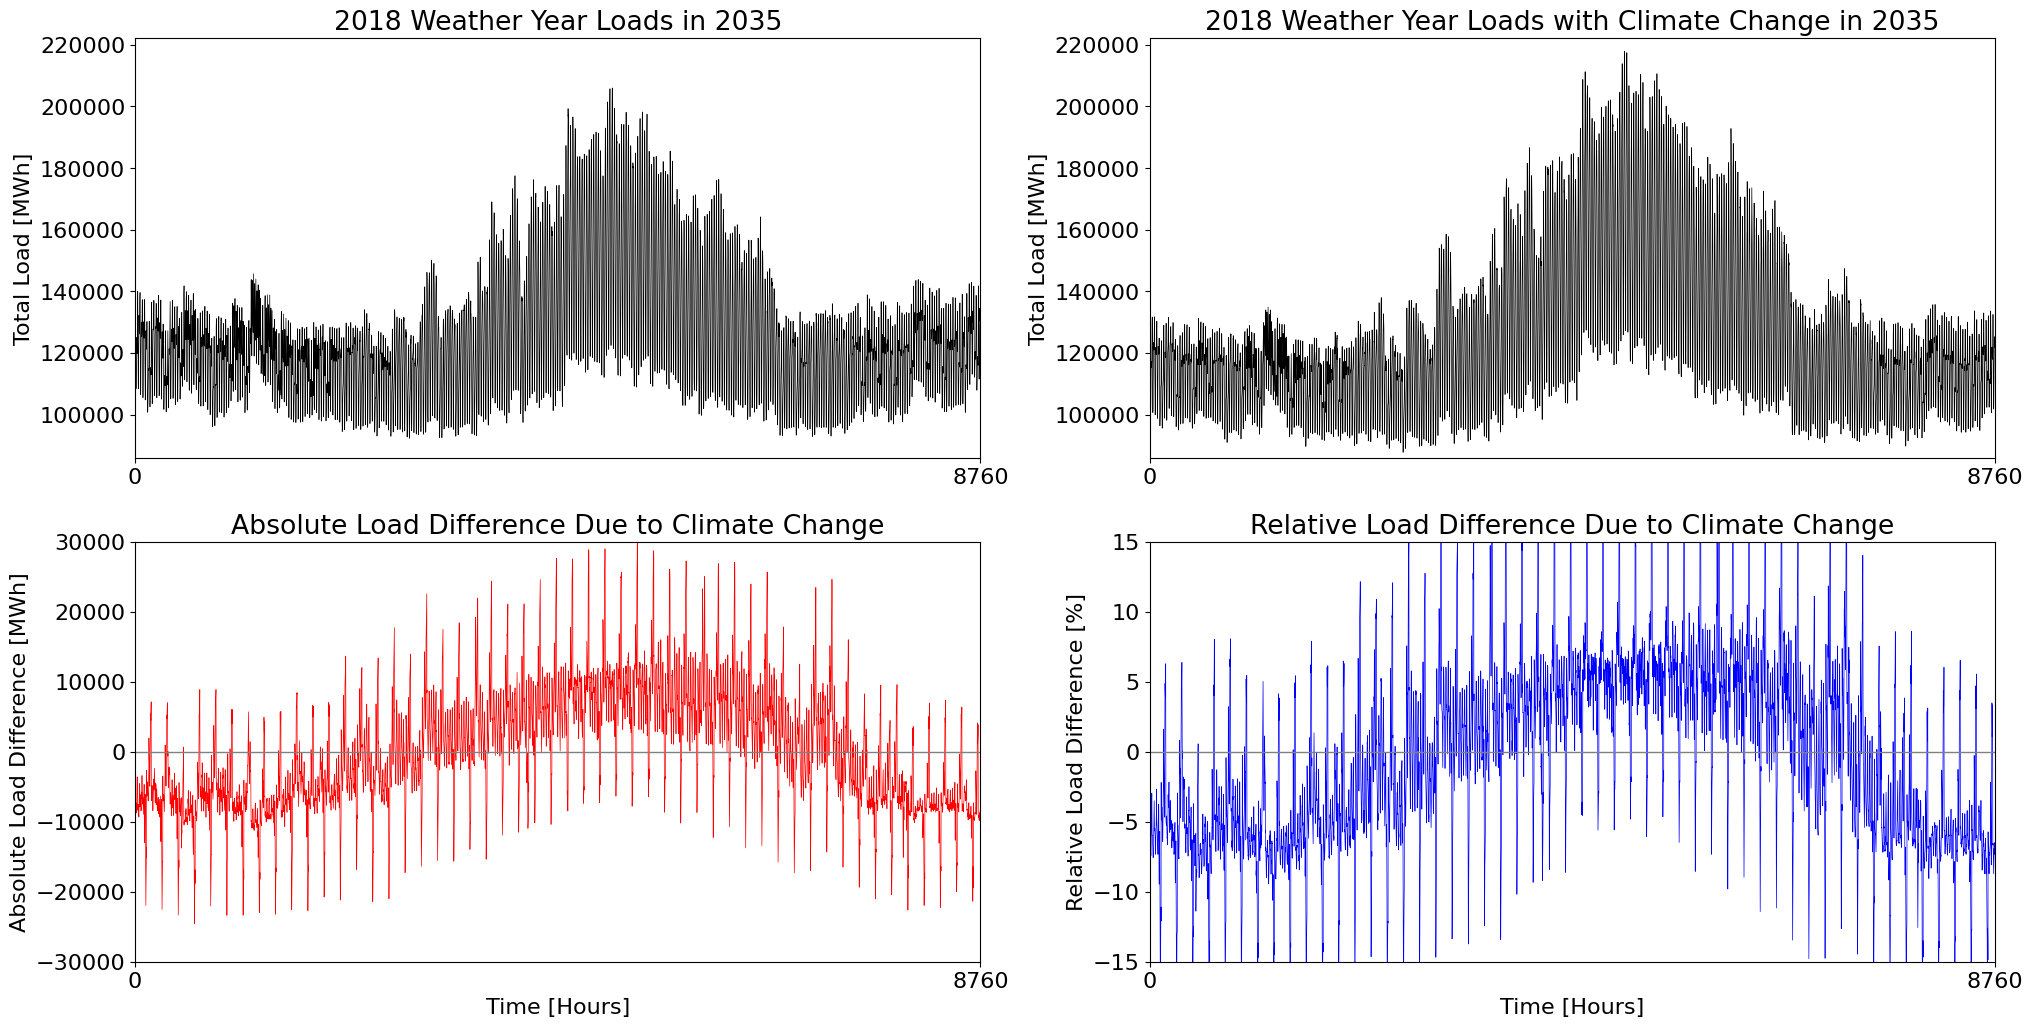

In [18]:
climate_change_impact_plots(data_dir = data_dir,
                            year_to_process = '2018',
                            image_output_dir = plot_dir, 
                            image_resolution = 300, 
                            save_images = True)


## Create a Function to Plot the Basic 8760 Time Series for a Given GridView Input File


In [51]:
def create_time_series_plots(data_dir: str, year_to_process: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Set the output filename:
    if year_to_process == '2035':
       input_filename = 'wecc_load_2035.csv'
       plot_title = '2035 Base Total Load'
       line_color = 'black' 
    if year_to_process == '2015':
       input_filename = 'TELL_Loads_2035_Based_on_2015_Weather_With_Climate_Change.csv'
       plot_title = '2035 Total Load Based on 2015 Weather With Climate Change'
       line_color = 'blue' 
    if year_to_process == '2018':
       input_filename = 'TELL_Loads_2035_Based_on_2018_Weather_With_Climate_Change.csv'
       plot_title = '2035 Total Load Based on 2015 Weather With Climate Change'
       line_color = 'red'  
    
    # Read in the raw TELL data .csv file:
    tell_df = pd.read_csv((data_dir + input_filename))
    
    # Strip the unecessary bits from the column names:
    tell_df.columns = tell_df.columns.str.replace("_CEC", "")
    tell_df.columns = tell_df.columns.str.replace("_2030.dat", "")
    tell_df.columns = tell_df.columns.str.replace("Load_", "")
    
    # Subset to just the annual total demand by BA:
    tell_stats = tell_df[8791:8795]
    
    # Reshape the dataframe and rename the index column:
    tell_stats_df = pd.melt(tell_stats, id_vars='Index', var_name='BA', value_name='TELL_Value')
    tell_stats_df.rename(columns={'Index': 'Statistic'}, inplace=True)
    
    # Drop the first row and last 4 rows:
    tell_df = tell_df.tail(-1).iloc[:-4, :]
    
    # Compute the hourly total load across BAs:
    tell_df['TELL_Total_Load_MWh'] = tell_df.sum(axis=1)
    
    # Copy the total load to a new dataframe:
    tell_load_df = tell_df[['Index', 'TELL_Total_Load_MWh']].copy().iloc[0:8760, :]
    tell_load_df.rename(columns={'Index': 'Hour'}, inplace=True)
    
    print(tell_load_df['TELL_Total_Load_MWh'].max())
    
    # Make the total load time series plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    if year_to_process == '2015':
       plt.fill_between([4200, 4200, 4392, 4392], [80000, 220000, 220000, 80000], color='blue', alpha=0.15)
    if year_to_process == '2018':
       plt.fill_between([4848, 4848, 5016, 5016], [80000, 220000, 220000, 80000], color='red', alpha=0.15)
    plt.plot(tell_load_df['Hour'], tell_load_df['TELL_Total_Load_MWh'], color=line_color, linestyle='-', linewidth=0.75)
    plt.xlim([0, 8760]); 
    plt.xticks([0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016, 8760],['1-Jan', '1-Feb', '1-Mar', '1-Apr', '1-May', '1-Jun', '1-Jul', '1-Aug', '1-Sep', '1-Oct', '1-Nov', '1-Dec', '1-Jan']); 
    plt.xlabel('')
    plt.ylim([80000, 220000]); 
    plt.ylabel('WECC Total Load [MWh]')
    plt.title(plot_title)
        
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, 'WECC_Loads_' + year_to_process + '.png'), dpi=image_resolution, bbox_inches='tight', facecolor='white')


185542.71436949997


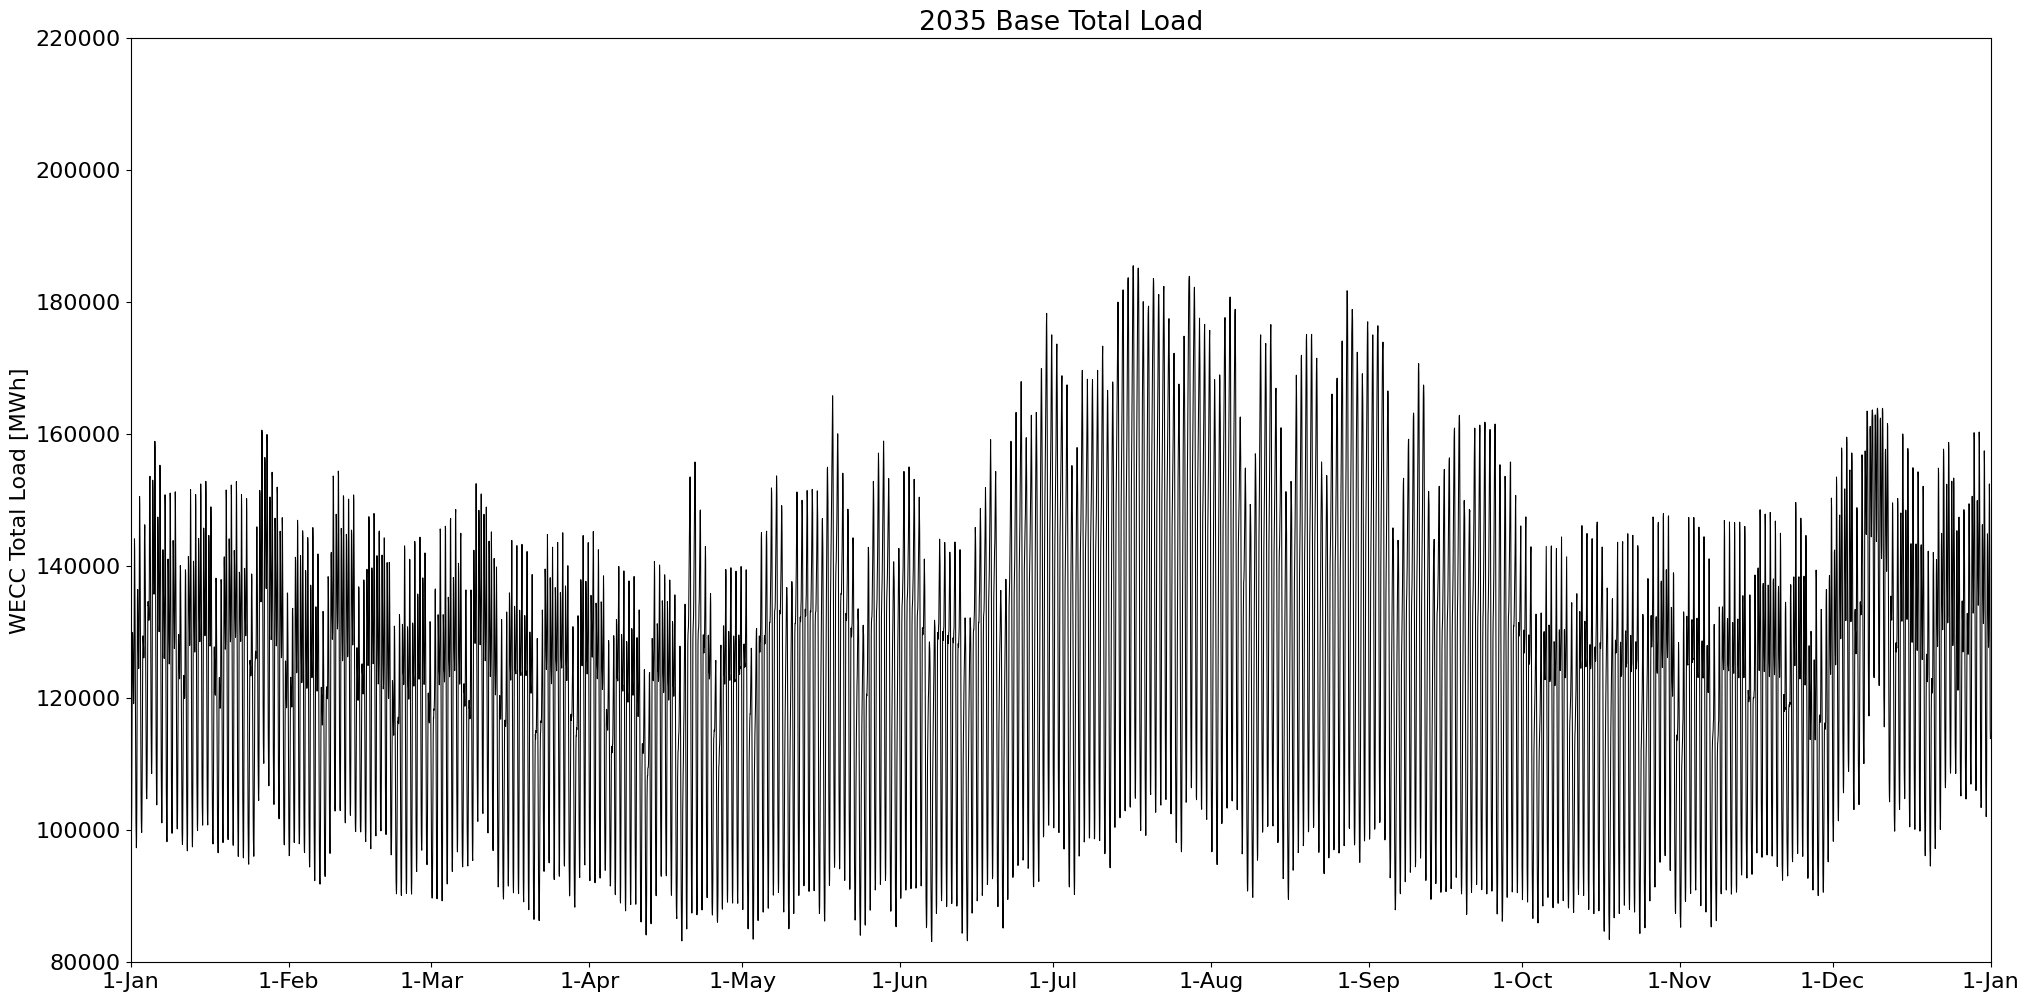

In [54]:
create_time_series_plots(data_dir = data_dir,
                         year_to_process = '2035',
                         image_output_dir = plot_dir, 
                         image_resolution = 300, 
                         save_images = False)


## Create a Function to Calculate Changes in Minimum and Maximum Loads by BA


In [101]:
def create_delta_plots(data_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Loop over the years
    for year in [2015, 2018, 2035]:
        
        # Set the output filename:
        if str(year) == '2035':
           input_filename = 'wecc_load_2035.csv'
        if str(year) == '2015':
           input_filename = 'TELL_Loads_2035_Based_on_2015_Weather_With_Climate_Change.csv'
        if str(year) == '2018':
           input_filename = 'TELL_Loads_2035_Based_on_2018_Weather_With_Climate_Change.csv' 
    
        # Read in the raw TELL data .csv file:
        tell_df = pd.read_csv((data_dir + input_filename))
    
        # Strip the unecessary bits from the column names:
        tell_df.columns = tell_df.columns.str.replace("_CEC", "")
        tell_df.columns = tell_df.columns.str.replace("_2030.dat", "")
        tell_df.columns = tell_df.columns.str.replace("Load_", "")
    
        # Subset to just the annual max demand by BA:
        max_df = pd.DataFrame(tell_df.filter(items=[8793], axis=0).drop('Index', axis=1).squeeze()).reset_index()
        max_df.rename(columns={'index': 'BA'}, inplace=True)
        if year == 2015:
           max_df.rename(columns={max_df.columns[1]: 'Max_Load_2015'}, inplace=True)
        if year == 2018:
           max_df.rename(columns={max_df.columns[1]: 'Max_Load_2018'}, inplace=True)
        if year == 2035:
           max_df.rename(columns={max_df.columns[1]: 'Max_Load_2035'}, inplace=True)
    
        # Subset to just the annual min demand by BA:
        min_df = pd.DataFrame(tell_df.filter(items=[8794], axis=0).drop('Index', axis=1).squeeze()).reset_index()
        min_df.rename(columns={'index': 'BA'}, inplace=True)
        if year == 2015:
           min_df.rename(columns={min_df.columns[1]: 'Min_Load_2015'}, inplace=True)
        if year == 2018:
           min_df.rename(columns={min_df.columns[1]: 'Min_Load_2018'}, inplace=True)
        if year == 2035:
           min_df.rename(columns={min_df.columns[1]: 'Min_Load_2035'}, inplace=True)
    
        if year == 2015:
           # Assign the output_df as the temp_df:  
           output_df = max_df.merge(min_df, on=['BA'])
        else:
           # Merge the output_df and temp_df dataframes based on common BA names:
           output_df = output_df.merge(max_df, on=['BA'])
           output_df = output_df.merge(min_df, on=['BA'])
        
        # Clean up and move to the next year:
        del tell_df, max_df, min_df, input_filename
    
    # Compute the min and max loads:
    max_min_load = 1.05*output_df[['Min_Load_2015', 'Min_Load_2018', 'Min_Load_2035']].max().max().max()
    min_max_load = 0.95*output_df[['Max_Load_2015', 'Max_Load_2018', 'Max_Load_2035']].min().min().min()
    max_max_load = 1.05*output_df[['Max_Load_2015', 'Max_Load_2018', 'Max_Load_2035']].max().max().max()
    
    # Make the plot:
    plt.figure(figsize=(20, 15))
    plt.rcParams['font.size'] = 15
    
    plt.subplot(221)
    plt.plot([0, max_min_load], [0, max_min_load], color='k', linestyle='-', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.8*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.9*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.1*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.2*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Min_Load_2035'], output_df['Min_Load_2015'], s=50, c='blue')
    plt.xlim([0, max_min_load]); plt.ylim([0, max_min_load]);
    plt.xlabel('NTP Base Year Min Load [MWh]')
    plt.ylabel('2015 Weather Year Min Load [MWh]')
    plt.title('BA Annual Minimum Load: 2015 Comparison')
    
    plt.subplot(222)
    plt.plot([0, max_min_load], [0, max_min_load], color='k', linestyle='-', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.8*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.9*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.1*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.2*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Min_Load_2035'], output_df['Min_Load_2018'], s=50, c='red')
    plt.xlim([0, max_min_load]); plt.ylim([0, max_min_load]);
    plt.xlabel('NTP Base Year Min Load [MWh]')
    plt.ylabel('2018 Weather Year Min Load [MWh]')
    plt.title('BA Annual Minimum Load: 2018 Comparison')
    
    plt.subplot(223)
    plt.plot([min_max_load, max_max_load], [min_max_load, max_max_load], color='k', linestyle='-', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.8*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.9*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.1*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.2*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Max_Load_2035'], output_df['Max_Load_2015'], s=50, c='blue')
    plt.xlim([min_max_load, max_max_load]); plt.ylim([min_max_load, max_max_load]);
    plt.xlabel('NTP Base Year Max Load [MWh]')
    plt.ylabel('2015 Weather Year Max Load [MWh]')
    plt.title('BA Annual Maximum Load: 2015 Comparison')
    
    plt.subplot(224)
    plt.plot([min_max_load, max_max_load], [min_max_load, max_max_load], color='k', linestyle='-', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.8*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.9*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.1*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.2*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Max_Load_2035'], output_df['Max_Load_2018'], s=50, c='red')
    plt.xlim([min_max_load, max_max_load]); plt.ylim([min_max_load, max_max_load]);
    plt.xlabel('NTP Base Year Max Load [MWh]')
    plt.ylabel('2018 Weather Year Max Load [MWh]')
    plt.title('BA Annual Maximum Load: 2018 Comparison')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, 'Delta_Plots.png'), dpi=image_resolution, bbox_inches='tight', facecolor='white')

    return output_df
    

,BA,Max_Load_2015,Min_Load_2015,Max_Load_2018,Min_Load_2018,Max_Load_2035,Min_Load_2035
0,AVA,3149.867330,1170.532690,3193.241780,1134.983250,2834.934081,1239.254300
1,AZPS,11125.282210,3183.076160,11398.190130,3125.157190,10019.953290,3036.639987
2,BANC,6179.225140,1757.708070,6093.529070,1786.000830,4270.590948,1757.525323
3,BPAT,10771.927310,5349.311750,11577.357390,5381.382010,11053.312880,4838.325546
4,CHPD,494.414330,136.364770,538.228380,136.139650,397.668924,173.243905
5,CIPB,11773.458477,4349.046942,11984.839744,4421.634982,9816.394027,4039.853335
6,CIPV,13974.754861,5162.192996,14225.658314,5248.352901,11651.871980,4795.227318
7,CISC,36601.744686,13520.471160,37258.894254,13746.135429,30518.676140,12559.731550
8,CISD,7849.276464,2899.476978,7990.202769,2947.870879,6545.115735,2693.573851
9,DOPD,695.060100,246.831630,699.425940,256.249190,633.216109,275.887251


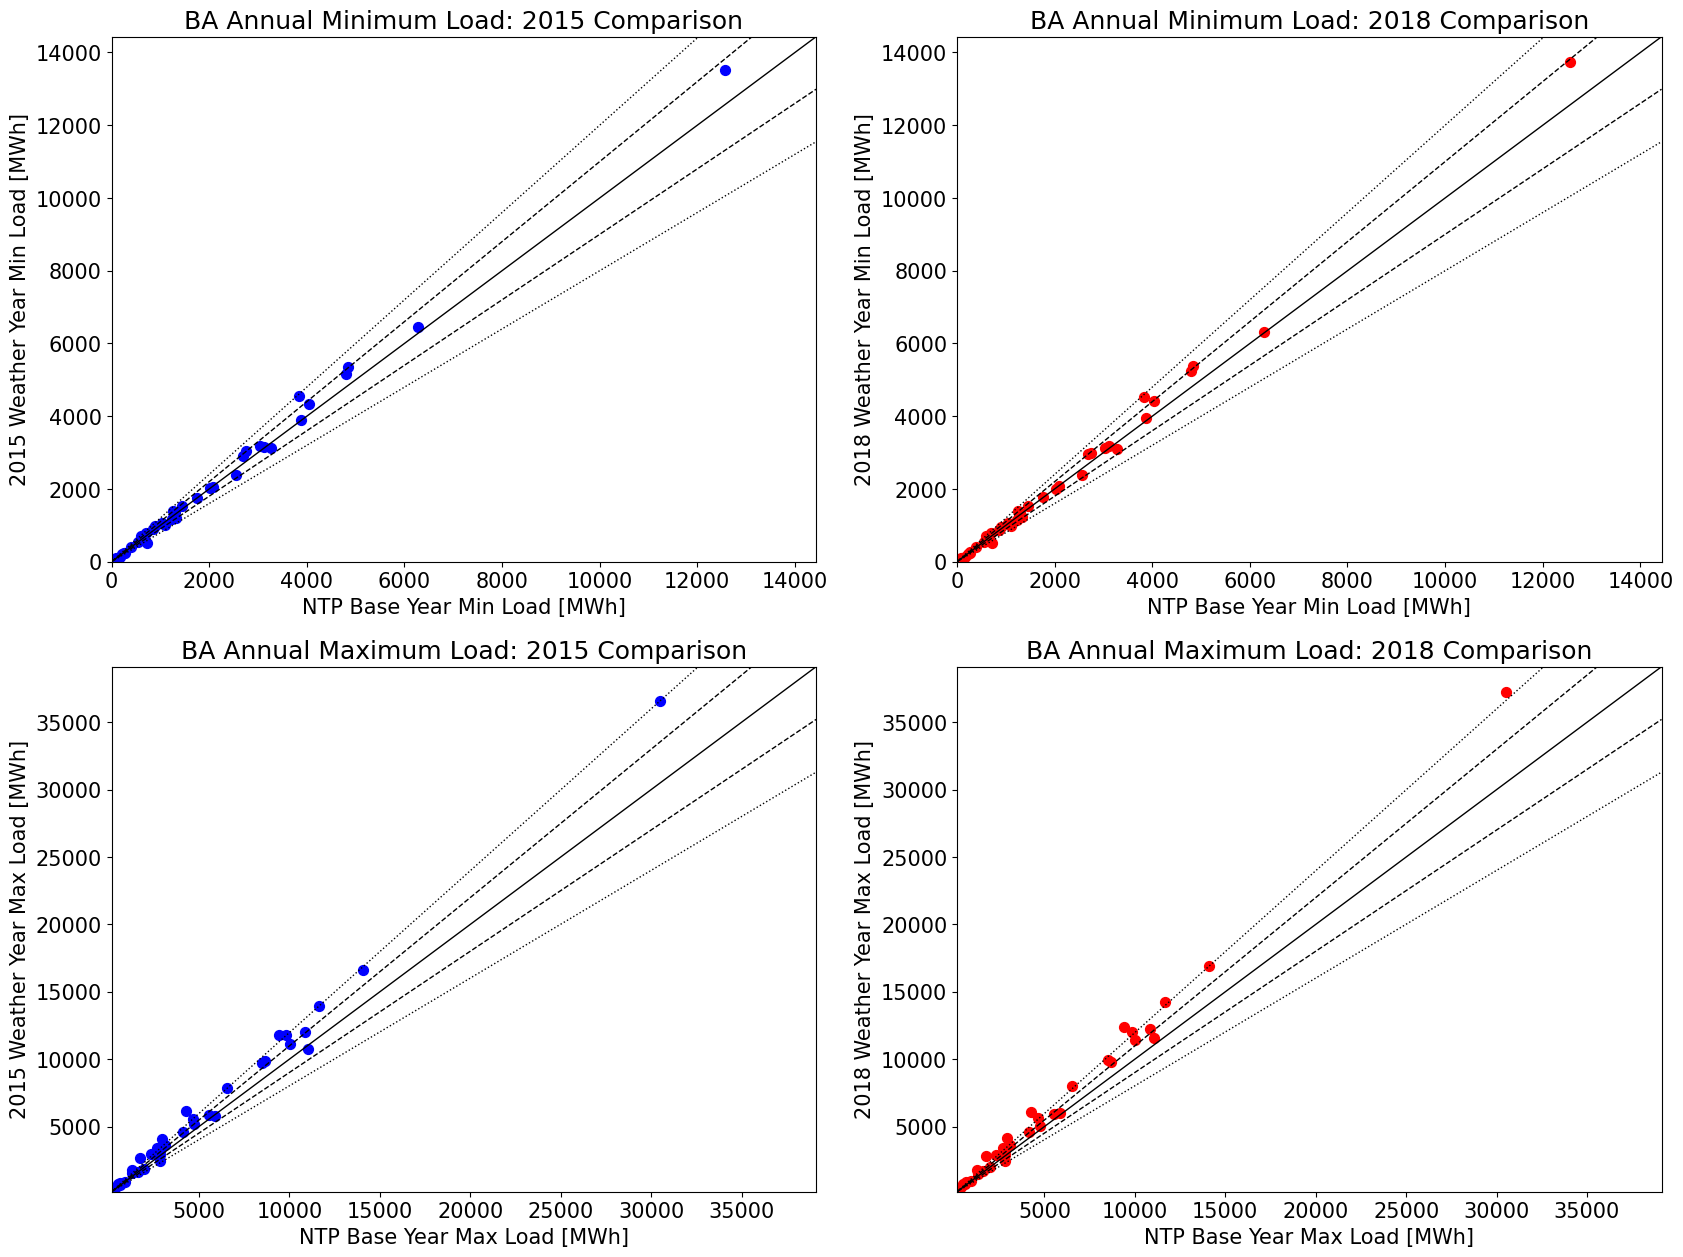

In [102]:
a = create_delta_plots(data_dir = data_dir,
                       image_output_dir = plot_dir, 
                       image_resolution = 300, 
                       save_images = True)

a
